In [1]:
import numpy as np
import pandas as pd

import torch
import time
import copy
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, cross_val_score

import brevitas.nn as nn

from config import *
from classic_models import *
from data_preprocessing import *
from feature_extraction import *
from helpers import *

from torch.utils.data import DataLoader
from tslearn.preprocessing import TimeSeriesScalerMinMax

import warnings
warnings.filterwarnings("ignore")

In [34]:
from sklearn import preprocessing
df = pd.read_csv('out_2.csv')
# temp = df['tag']
# del df['tag']

# x = df.values #returns a numpy array
# col = df.columns
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled, columns=col)

# df['tag'] = temp
df['tag'] = df['tag'].apply(lambda x: x-1)
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]

df_train.to_csv('df_train.csv')
df_test.to_csv('df_test.csv')

df.head()

,mean_accel1,mean_accel2,mean_accel3,mean_gyro1,mean_gyro2,mean_gyro3,max_accel1,max_accel2,max_accel3,max_gyro1,...,var_coeff_gyro1,var_coeff_gyro2,var_coeff_gyro3,kurtosis_accel1,kurtosis_accel2,kurtosis_accel3,kurtosis_gyro1,kurtosis_gyro2,kurtosis_gyro3,tag
0,0.321713,0.587304,0.19189,0.224644,0.132784,3.0,0.08,0.412742,-1.510622,0.425019,...,0.512475,0.670569,0.403010,0.465719,0.091719,1.0,0.46,0.178974,-1.346002,0.0
1,0.290898,0.515375,0.18489,0.219044,0.117643,3.0,0.12,0.404411,-1.121981,0.454103,...,0.506555,0.670569,0.403010,0.467391,0.089168,1.0,0.42,0.176028,-1.119453,0.0
2,0.261652,0.499783,0.16476,0.215231,0.098955,3.0,0.12,0.378192,0.209323,0.482450,...,0.510602,0.670569,0.403010,0.469900,0.086363,2.0,0.34,0.169140,-1.079949,0.0
3,0.236798,0.463143,0.16476,0.212382,0.072249,3.0,0.12,0.305106,3.957013,0.498670,...,0.507860,0.670569,0.341137,0.469900,0.089625,2.0,0.38,0.176476,-0.980839,0.0
4,0.221092,0.355008,0.16476,0.212382,0.035674,3.0,0.12,0.161354,4.649814,0.501705,...,0.472475,0.670569,0.177258,0.461538,0.115898,2.0,0.34,0.245300,0.466311,0.0


In [3]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        if isinstance(df, pd.DataFrame):
            df_np = df.to_numpy()

        self.X = df_np[:,:-1]
        self.y = df_np[:,-1]

    def __getitem__(self, idx):
        # get item by index
        return self.X[idx], self.y[idx]

    def __len__(self):
        # returns length of data
        return len(self.X)

In [4]:
dataset = FeatureDataset(df_train)
D_in = df.shape[1]-1
D_out = len(dances)

In [5]:
class MLP(torch.nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(MLP, self).__init__()
        self.d_in = d_in

        self.linear1 = nn.QuantLinear(d_in, d_hidden, bias=True)#, weight_bit_width=4)
        self.linear2 = nn.QuantLinear(d_hidden, d_hidden, bias=True)#, weight_bit_width=4)
        self.linear3 = nn.QuantLinear(d_hidden, d_out, bias=False)#, weight_bit_width=4)
        
        self.relu = torch.nn.ReL(p=0.1)

    def forward(self, X):
        X = X.view(-1, self.d_in)
        X = self.linear1(X.float())
        X = self.linear2(X)
        X = self.linear3(X)
        return torch.nn.functional.sigmoid(X)
    
    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()

    def predict(self, X):
        outputs = self(X.float())
        _, predicted = torch.max(outputs, 1)
        return predicted

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(MLP, self).__init__()
        self.d_in = d_in

        self.linear1 = nn.QuantLinear(d_in, d_hidden, bias=True)
        self.linear2 = nn.QuantLinear(d_hidden, d_hidden//4, bias=True)
        self.linear3 = nn.QuantLinear(d_hidden//4, d_out, bias=False)

        self.dropout = torch.nn.Dropout(p=0.1)
        self.relu = torch.nn.ReLU()
        
    def forward(self, X):
        X = X.view(-1, self.d_in)
        X = self.relu(self.linear1(X.float()))
        # X = self.dropout(X)
        X = self.relu(self.linear2(X))
        X = self.linear3(X)
        # X = self.dropout(X)
        return torch.nn.functional.log_softmax(X, dim=1)
    
    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()

    def predict(self, X):
        outputs = self(X.float())
        _, predicted = torch.max(outputs, 1)
        return predicted

In [7]:
def train_val_model(model, criterion, optimizer, X, y, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    tscv = TimeSeriesSplit(n_splits=20)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    for i in range(1,num_epochs+1):
        print('Epoch {}/{}'.format(i, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
        for fold, (train_index, test_index) in enumerate(tscv.split(X_train, y_train)):
            ### Dividing data into folds
            x_train_fold = X_train[train_index]
            x_test_fold = X_train[test_index]
            y_train_fold = y_train[train_index]
            y_test_fold = y_train[test_index]

            print('Train Index Length:', len(train_index), end='\t\t')
            print('Test Index Length:', len(test_index), end='\n\n')

            train = torch.utils.data.TensorDataset(torch.tensor(x_train_fold), torch.tensor(y_train_fold))
            test = torch.utils.data.TensorDataset(torch.tensor(x_test_fold), torch.tensor(y_test_fold))
            train_loader = torch.utils.data.DataLoader(train, batch_size = 10, shuffle = False)
            test_loader = torch.utils.data.DataLoader(test, batch_size = 10, shuffle = False)

            running_loss = 0.0
            running_corrects = 0
            for batch_index, (x_batch, y_batch) in enumerate(train_loader):
                optimizer.zero_grad()
                y_pred = model(x_batch)
                _, preds = torch.max(y_pred, 1)
                # print(y_pred.shape, y_batch.view(-1, 1).shape)
                single_loss = criterion(y_pred, y_batch.long())
                single_loss.backward()
                optimizer.step()
                
                running_loss += single_loss.item() * x_batch.size(0)
                running_corrects += torch.sum(preds == y_batch.data)
            print('Fold No. {}/{}\tEpoch {}/{}\t'.format(fold + 1 , tscv.get_n_splits(), i, num_epochs), end='')
            print(f'loss: {single_loss.item():10.8f}')
            
            nsamples = len(train_index)
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc)
            )
            print()

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

In [8]:
model = MLP(D_in, 50, D_out)
# model = MultiHead4MLP(D_in, D_out)
# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

torch.Size([50, 54])
torch.Size([50])
torch.Size([12, 50])
torch.Size([12])
torch.Size([3, 12])
Total number of parameters = 3398


In [9]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = torch.nn.NLLLoss()

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataset.X, dataset.y, num_epochs=8)

Epoch 1/8
----------
Train Index Length: 46		Test Index Length: 30

Fold No. 1/20	Epoch 1/8	loss: 1.09689128
val Loss: 1.1284 Acc: 23.91%

Train Index Length: 76		Test Index Length: 30

Fold No. 2/20	Epoch 1/8	loss: 1.06161225
val Loss: 1.0998 Acc: 31.58%

Train Index Length: 106		Test Index Length: 30

Fold No. 3/20	Epoch 1/8	loss: 1.05936587
val Loss: 1.0879 Acc: 35.85%

Train Index Length: 136		Test Index Length: 30

Fold No. 4/20	Epoch 1/8	loss: 1.08360898
val Loss: 1.0681 Acc: 50.74%

Train Index Length: 166		Test Index Length: 30

Fold No. 5/20	Epoch 1/8	loss: 1.00826502
val Loss: 1.0498 Acc: 64.46%

Train Index Length: 196		Test Index Length: 30

Fold No. 6/20	Epoch 1/8	loss: 1.05543435
val Loss: 1.0226 Acc: 66.84%

Train Index Length: 226		Test Index Length: 30

Fold No. 7/20	Epoch 1/8	loss: 1.04912412
val Loss: 0.9808 Acc: 69.47%

Train Index Length: 256		Test Index Length: 30

Fold No. 8/20	Epoch 1/8	loss: 1.14934146
val Loss: 0.9239 Acc: 69.14%

Train Index Length: 286		Test

Fold No. 9/20	Epoch 4/8	loss: 0.12059321
val Loss: 0.1275 Acc: 94.76%

Train Index Length: 316		Test Index Length: 30

Fold No. 10/20	Epoch 4/8	loss: 0.14036196
val Loss: 0.1122 Acc: 95.89%

Train Index Length: 346		Test Index Length: 30

Fold No. 11/20	Epoch 4/8	loss: 0.13380247
val Loss: 0.1176 Acc: 95.38%

Train Index Length: 376		Test Index Length: 30

Fold No. 12/20	Epoch 4/8	loss: 0.06392702
val Loss: 0.1099 Acc: 94.95%

Train Index Length: 406		Test Index Length: 30

Fold No. 13/20	Epoch 4/8	loss: 0.00953544
val Loss: 0.0997 Acc: 96.31%

Train Index Length: 436		Test Index Length: 30

Fold No. 14/20	Epoch 4/8	loss: 0.00427880
val Loss: 0.1070 Acc: 96.10%

Train Index Length: 466		Test Index Length: 30

Fold No. 15/20	Epoch 4/8	loss: 0.46337616
val Loss: 0.1093 Acc: 95.92%

Train Index Length: 496		Test Index Length: 30

Fold No. 16/20	Epoch 4/8	loss: 0.05412479
val Loss: 0.1170 Acc: 95.77%

Train Index Length: 526		Test Index Length: 30

Fold No. 17/20	Epoch 4/8	loss: 0.21415812

Fold No. 18/20	Epoch 7/8	loss: 0.13728744
val Loss: 0.0622 Acc: 97.48%

Train Index Length: 586		Test Index Length: 30

Fold No. 19/20	Epoch 7/8	loss: 0.01192030
val Loss: 0.0915 Acc: 96.76%

Train Index Length: 616		Test Index Length: 30

Fold No. 20/20	Epoch 7/8	loss: 0.54906684
val Loss: 0.0844 Acc: 96.75%

Epoch 8/8
----------
Train Index Length: 46		Test Index Length: 30

Fold No. 1/20	Epoch 8/8	loss: 0.02222370
val Loss: 0.0865 Acc: 95.65%

Train Index Length: 76		Test Index Length: 30

Fold No. 2/20	Epoch 8/8	loss: 0.01373388
val Loss: 0.0328 Acc: 98.68%

Train Index Length: 106		Test Index Length: 30

Fold No. 3/20	Epoch 8/8	loss: 0.08732905
val Loss: 0.0320 Acc: 99.06%

Train Index Length: 136		Test Index Length: 30

Fold No. 4/20	Epoch 8/8	loss: 0.00034225
val Loss: 0.0341 Acc: 98.53%

Train Index Length: 166		Test Index Length: 30

Fold No. 5/20	Epoch 8/8	loss: 0.00340057
val Loss: 0.0337 Acc: 98.80%

Train Index Length: 196		Test Index Length: 30

Fold No. 6/20	Epoch 8/8	lo

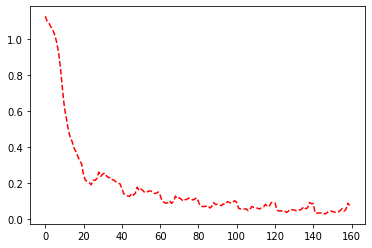

In [10]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [11]:
torch.save(model.state_dict(), 'MLP_Model')

In [33]:
mlp_model = MLP(D_in, 50, D_out)
mlp_model.load('MLP_Model')
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in mlp_model.state_dict():
    print(param_tensor, "\t\t", mlp_model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")

with open('weights.txt', 'w') as outfile:
    for var_name in optimizer.state_dict():
        if var_name == 'state':
            for i in range(len(mlp_model.state_dict())):
                print(var_name, "\t", optimizer.state_dict()[var_name][i]['momentum_buffer'].shape)
                # print(var_name, "\t", np.array(optimizer.state_dict()[var_name][i]['momentum_buffer']))
                y = np.array(optimizer.state_dict()[var_name][i]['momentum_buffer'])
                for x in y:
                    x = str(x)
                    x = x.replace('[','{').replace(']','}').replace(' ', ', ').replace('{,', '{').replace(', ,', ',').replace('\n,', ',\n')
                    print(x)
                    outfile.write(x)
                # np.savetxt(outfile, np.array(optimizer.state_dict()[var_name][i]['momentum_buffer'])

Model's state_dict:
linear1.weight 		 torch.Size([50, 54])
linear1.bias 		 torch.Size([50])
linear2.weight 		 torch.Size([12, 50])
linear2.bias 		 torch.Size([12])
linear3.weight 		 torch.Size([3, 12])
Optimizer's state_dict:
state 	 torch.Size([50, 54])
{-5.89698292e-02, -9.99343395e-02, -5.03485911e-02, -5.69856539e-02,
 -7.16278236e-03, -1.58877718e+00, 8.11489183e-04, -4.37823460e-02,
 -2.54934955e+00, -1.62832171e-01, -1.87072501e-01, -6.81562573e-02,
 -1.77684218e-01, -3.19299772e-02, -5.23579359e-01, 1.15196905e-04,
 -5.70112206e-02, -3.88996303e-01, -1.42749920e-01, -1.58009648e-01,
 -1.17020376e-01, -1.43296957e-01, -7.37844640e-03, -1.20320511e+00,
 -1.08741503e-02, -1.58869419e-02, 3.08965836e-02, -1.29745901e-01,
 -1.51776612e-01, -1.11113183e-01, -1.26800343e-01, -1.10895410e-02,
 -4.92134959e-01, -1.45323932e-01, -2.52179150e-02, 2.18075201e-01,
 -1.39375851e-01, -1.64502308e-01, -1.29130647e-01, -1.35496438e-01,
 -8.68450757e-03, -6.09673917e-01, -2.44947672e-01, -1.8266

In [13]:
mlp_model = MLP(D_in, 50, D_out)
mlp_model.load('MLP_Model')
mlp_model.eval()

for to_predict in range(D_out):
    df_target = df_test[df_test['tag'] == to_predict]

    df_random = df_test

    df_filtered = torch.from_numpy(np.array(pd.merge(df_target, df_random))[:,:-1])
    output = mlp_model.predict(df_filtered)
    # print(output)
    proba_dict = {}

    for x in output:
        x = int(x)
        if x not in proba_dict:
            proba_dict[x] = 1
        else:
            proba_dict[x] += 1
    for k in proba_dict.keys():
        proba_dict[k] /= len(output)

    print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

{0: 0.9333333333333333, 1: 0.03333333333333333, 2: 0.03333333333333333}
{1: 0.9807692307692307, 0: 0.019230769230769232}
{2: 0.9629629629629629, 0: 0.037037037037037035}


In [241]:
D_in

54

## Hierarchical Test

In [ ]:
df_hierarchical = df.copy()
df_hierarchical['tag'] = df_hierarchical['tag'].apply(lambda x: 0 if x <= 7 else 1)

msk = np.random.rand(len(df_hierarchical)) < 0.8
df_train = df_hierarchical[msk]
df_test = df_hierarchical[~msk]

dataset = FeatureDataset(df_train)

In [ ]:
model_hierarchical = MLP(D_in, 50, 2)
optimizer = torch.optim.SGD(model_hierarchical.parameters(), lr=0.01, momentum=0.5)
criterion = torch.nn.NLLLoss()
model, losses, accuracies = train_val_model(model_hierarchical, criterion, optimizer, dataset.X, dataset.y, num_epochs=5)

In [ ]:
torch.save(model.state_dict(), 'MLP_Model_Hierarchical_1')

In [ ]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
mlp_model = MLP(D_in, 50, 2)
mlp_model.load('MLP_Model_Hierarchical_1')
mlp_model.eval()

for to_predict in range(2):
    df_target = df_test[df_test['tag'] == to_predict]

    df_random = df_test

    df_filtered = torch.from_numpy(np.array(pd.merge(df_target, df_random))[:,:-1])
    output = mlp_model.predict(df_filtered)
    # print(output)
    proba_dict = {}

    for x in output:
        x = int(x)
        if x not in proba_dict:
            proba_dict[x] = 1
        else:
            proba_dict[x] += 1
    for k in proba_dict.keys():
        proba_dict[k] /= len(output)
    print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

In [ ]:
df_hierarchical_2 = df.copy()
df_hierarchical_2 = df_hierarchical_2[df_hierarchical_2['tag'] >= 8]
df_hierarchical_2 = df_hierarchical_2.apply(lambda x: x-8)
msk = np.random.rand(len(df_hierarchical_2)) < 0.8
df_train = df_hierarchical_2[msk]
df_test = df_hierarchical_2[~msk]

dataset = FeatureDataset(df_train)

model_hierarchical_2 = MLP(D_in, 50, 2)
# optimizer = torch.optim.Adam(model_hierarchical_2.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(model_hierarchical_2.parameters(), lr=0.01, momentum=0.5)
criterion = torch.nn.CrossEntropyLoss()
model, losses, accuracies = train_val_model(model_hierarchical_2, criterion, optimizer, dataset.X, dataset.y, num_epochs=20)

torch.save(model.state_dict(), 'MLP_Model_Hierarchical_2')

In [ ]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
mlp_model = MLP(D_in, 50, 2)
mlp_model.load('MLP_Model_Hierarchical_2')
mlp_model.eval()

for to_predict in range(2):
    df_target = df_test[df_test['tag'] == to_predict]

    df_random = df_test

    df_filtered = torch.from_numpy(np.array(pd.merge(df_target, df_random))[:,:-1])
    output = mlp_model.predict(df_filtered)
    # print(output)
    proba_dict = {}

    for x in output:
        x = int(x) + 8
        if x not in proba_dict:
            proba_dict[x] = 1
        else:
            proba_dict[x] += 1
    for k in proba_dict.keys():
        proba_dict[k] /= len(output)

    print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

In [ ]:
df_hierarchical_3 = df.copy()
df_hierarchical_3 = df_hierarchical_3[df_hierarchical_3['tag'] < 8]
msk = np.random.rand(len(df_hierarchical_3)) < 0.8
df_train = df_hierarchical_3[msk]
df_test = df_hierarchical_3[~msk]

dataset = FeatureDataset(df_train)

model_hierarchical_3 = MLP(D_in, 50, 8)
# optimizer = torch.optim.Adam(model_hierarchical_2.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(model_hierarchical_3.parameters(), lr=0.01, momentum=0.5)
criterion = torch.nn.NLLLoss()
model, losses, accuracies = train_val_model(model_hierarchical_3, criterion, optimizer, dataset.X, dataset.y, num_epochs=30)

torch.save(model.state_dict(), 'MLP_Model_Hierarchical_3')

In [ ]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
mlp_model = MLP(D_in, 50, 8)
mlp_model.load('MLP_Model_Hierarchical_3')
mlp_model.eval()

for to_predict in range(8):
    df_target = df_test[df_test['tag'] == to_predict]

    df_random = df_test

    df_filtered = torch.from_numpy(np.array(pd.merge(df_target, df_random))[:,:-1])
    output = mlp_model.predict(df_filtered)
    # print(output)
    proba_dict = {}

    for x in output:
        x = int(x)
        if x not in proba_dict:
            proba_dict[x] = 1
        else:
            proba_dict[x] += 1
    for k in proba_dict.keys():
        proba_dict[k] /= len(output)

    print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))